# Experiment Visualization

This notebook provides visualizations of the experiments available in the Docker image and assumes that you have run all three experiments such that `results/globus-compute-tasks.csv`, `results/colmena-tasks.csv`, and `results/endpoint-qps.csv` exist.

In [1]:
%matplotlib inline

import math
import json
import os
import statistics
from typing import Any

from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy

## Experiment 1: Globus Compute Tasks

In [2]:
BACKEND_COLUMN = 'proxystore_backend'
INPUT_SIZE_COLUMN = 'input_size_bytes'
TOTAL_TIME_COLUMN = 'total_time_ms'
SLEEP_COLUMN = 'task_sleep_seconds'

def load(filepath: str) -> pandas.DataFrame:
    df = pandas.read_csv(filepath)
    df[BACKEND_COLUMN] = df[BACKEND_COLUMN].fillna('Globus Compute')
    return df

def get_backends(data: pandas.DataFrame) -> list[str]:
    return data[BACKEND_COLUMN].unique()

def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_input_sizes(data: pandas.DataFrame) -> list[int]:
    return list(data[INPUT_SIZE_COLUMN].unique())

def get_avg_total_time(data: pandas.DataFrame) -> float:
    """Drops min/max and takes average of remaining times."""
    times = list(data[TOTAL_TIME_COLUMN])
    if len(times) < 3:
        raise ValueError('Cannot drop min/max value when row count < 3')
    times.remove(min(times))
    times.remove(max(times))
    return sum(times) / len(times)

def extract_stdev_times(data: pandas.DataFrame):
    # Get Data for a particular backend
    backend_data = data[[INPUT_SIZE_COLUMN, TOTAL_TIME_COLUMN]].copy()
    
    TOTAL_TIME_S = 'total_time_s'
    # Convert total time of backend to seconds
    backend_data[TOTAL_TIME_S] = backend_data[TOTAL_TIME_COLUMN].div(1000)
    
    # drop min and max values for each input size
    backend_data = backend_data.drop(backend_data.groupby(INPUT_SIZE_COLUMN)[TOTAL_TIME_S].idxmin())
    backend_data = backend_data.drop(backend_data.groupby(INPUT_SIZE_COLUMN)[TOTAL_TIME_S].idxmax())

    backend_seconds = backend_data.groupby(INPUT_SIZE_COLUMN)
    
    # Return std as list
    return backend_seconds.std()[TOTAL_TIME_S].to_list()

def extract_avg_times(data: pandas.DataFrame) -> dict[str, list[str]]:
    # Input dataframe should just contain one backend type
    assert len(get_backends(data)) == 1
    input_sizes = get_input_sizes(data)
    input_sizes
    avg_times = [
        get_avg_total_time(rows_matching_column_value(data, INPUT_SIZE_COLUMN, input_size)) for input_size in input_sizes
    ]
    # Convert to seconds
    avg_times = [x / 1000 for x in avg_times]
    return {'sizes': input_sizes, 'times': avg_times, 'yerr': extract_stdev_times(data)}

def extract(data: pandas.DataFrame) -> dict[str, dict[str, list[str]]]:
    result = {}
    for backend in get_backends(data):
        subset = rows_matching_column_value(data, BACKEND_COLUMN, backend)
        result[backend] = extract_avg_times(subset)
    return result

In [3]:
data = extract(load('results/globus-compute-tasks.csv'))

backends = ['Globus Compute', 'FileConnector', 'RedisConnector', 'EndpointConnector']

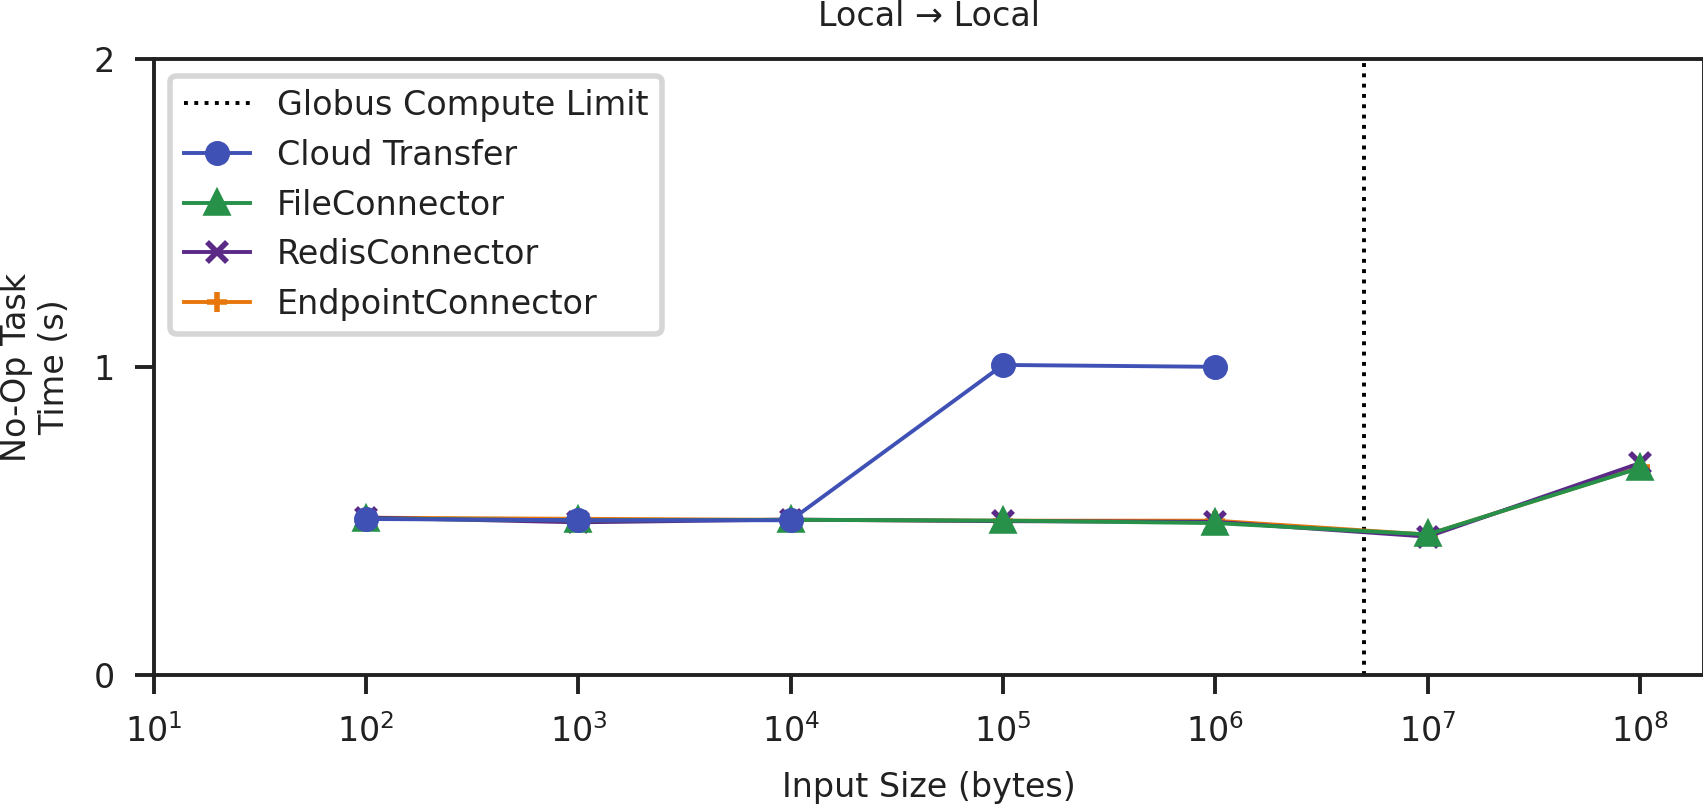

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(5, 2))

colors = plt.rcParams['axes.prop_cycle'] + cycler(marker=['o', '^', 'x', '+', 's', 'P'])
cycles = {b: c for b, c in zip(backends, colors)}
legend_handles = {}

ax.axvline(5e6, color='black', linestyle=':', label='Globus Compute Limit')

for backend in reversed(backends):
    if backend in data:                    
        xye = [
            (x, y, e)
            for x, y, e in zip(data[backend]['sizes'], data[backend]['times'], data[backend]['yerr'])
            if 0 < x < 1e9
        ]
        x, y, e  = zip(*xye)
        label = 'Cloud Transfer' if backend == 'Globus Compute' else backend
        ax.errorbar(x, y, yerr=e, label=label, **cycles[backend])

ax.set_xscale('symlog')
ax.set_xticks([10 ** x for x in range(1, 9)])

handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in legend_handles:
        legend_handles[label] = handle

ax.set_xlabel('Input Size (bytes)')
ax.set_ylabel('No-Op Task\nTime (s)')
ax.set_title('Local → Local')

handles = [None for _ in range(len(backends) + 1)]
labels = [None for _ in range(len(backends) + 1)]
for label, handle in legend_handles.items():
    if label =='Globus Compute Limit':
        index = 0
    elif label == 'Cloud Transfer':
        index = backends.index('Globus Compute') + 1
        handle = handle[0]
    else:
        index = backends.index(label) + 1
        handle = handle[0]
    handles[index] = handle
    labels[index] = label
    
ax.legend(handles, labels)
ax.set_ylim([0, 2])
ax.get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))

**Takeaway:** The ProxyStore options (File, Redis, and EndpointConnector) should eliminate the majority of the overhead related to data transfer resulting in lower round-trip task times. In addition, the Globus Compute service limits payload size to 5MB so the baseline cloud transfer option cannot support larger object sizes of 10^7 or 10^8 bytes, whereas transferring data via ProxyStore can.

## Experiment 2: Colmena Tasks

In [5]:
def load_and_extract(filepath: str, backend: str) -> list[dict[str, Any]]:
    df = pandas.read_csv(filepath)
    df['proxystore_backend'] = df['proxystore_backend'].fillna('Baseline')

    out = []
    for _, sample in df.iterrows():
        if sample['success'] and sample['proxystore_backend'] == backend:
            new = {
                'input_bytes': sample['input_size_bytes'],
                'output_bytes': sample['output_size_bytes'],
                'rtt': sample['time_result_received'] - sample['time_created'],                
            }
            out.append(new)
    return out
    
baseline_data_clean = load_and_extract('results/colmena-tasks.csv', 'Baseline')
filestore_data_clean = load_and_extract('results/colmena-tasks.csv', 'FileConnector')
redisstore_data_clean = load_and_extract('results/colmena-tasks.csv', 'RedisConnector')

In [6]:
def unique_values(data: list[dict[str, Any]], name: str) -> list[Any]:
    return set(sample[name] for sample in data)

def matching(data: list[dict[str, Any]], **kwargs) -> list[dict[str, Any]]:
    out = []
    for sample in data:
        for key, value in kwargs.items():
            if sample[key] != value:
                break
        else:
            out.append(sample)
    return out

def aggregate(data: list[dict[str, Any]]) -> list[dict[str, Any]]:
    input_sizes = sorted(unique_values(data, 'input_bytes'), reverse=True)
    output_sizes = sorted(unique_values(data, 'output_bytes'), reverse=True)
    out = []
    
    for input_size in input_sizes:
        for output_size in output_sizes:
            samples = matching(data, input_bytes=input_size, output_bytes=output_size)
            rtts = [sample['rtt'] for sample in samples]
            new = {
                'input_bytes': input_size,
                'output_bytes': output_size,
                'median_rtt': statistics.median(rtts),
                'mean_rtt': sum(rtts) / len(rtts),
                'min_rtt': min(rtts),
                'max_rtss': max(rtts),
                'std_rtt': statistics.stdev(rtts),
            }
            out.append(new)
    return out

baseline_data_aggregate = aggregate(baseline_data_clean)
filestore_data_aggregate = aggregate(filestore_data_clean)
redisstore_data_aggregate = aggregate(redisstore_data_clean)

In [7]:
def improvement(starting: list[dict[str, float]], final: list[dict[str, float]]) -> list[dict[str, float]]:
    out = []
    for baseline in starting:
        sample = matching(final, input_bytes=baseline['input_bytes'], output_bytes=baseline['output_bytes'])
        assert len(sample) == 1
        sample = sample.pop()
        new = {
            'input_bytes': baseline['input_bytes'],
            'output_bytes': baseline['output_bytes'],
            'median_rtt_improvement_percent': (baseline['median_rtt'] - sample['median_rtt']) / baseline['median_rtt'],
        }
        out.append(new)
    return out

filestore_changes = improvement(baseline_data_aggregate, filestore_data_aggregate)
redisstore_changes = improvement(baseline_data_aggregate, redisstore_data_aggregate)

def matrixify(data: list[dict[str, float]]) -> list[list[float]]:
    x_values = sorted(unique_values(data, 'input_bytes'), reverse=True)
    y_values = sorted(unique_values(data, 'output_bytes'), reverse=False)
    
    rows = []
    for xval in x_values:
        row = []
        for yval in y_values:
            sample = matching(data, input_bytes=xval, output_bytes=yval)
            assert len(sample) == 1
            sample = sample.pop()
            row.append(sample['median_rtt_improvement_percent'])
        rows.append(row)
    return rows

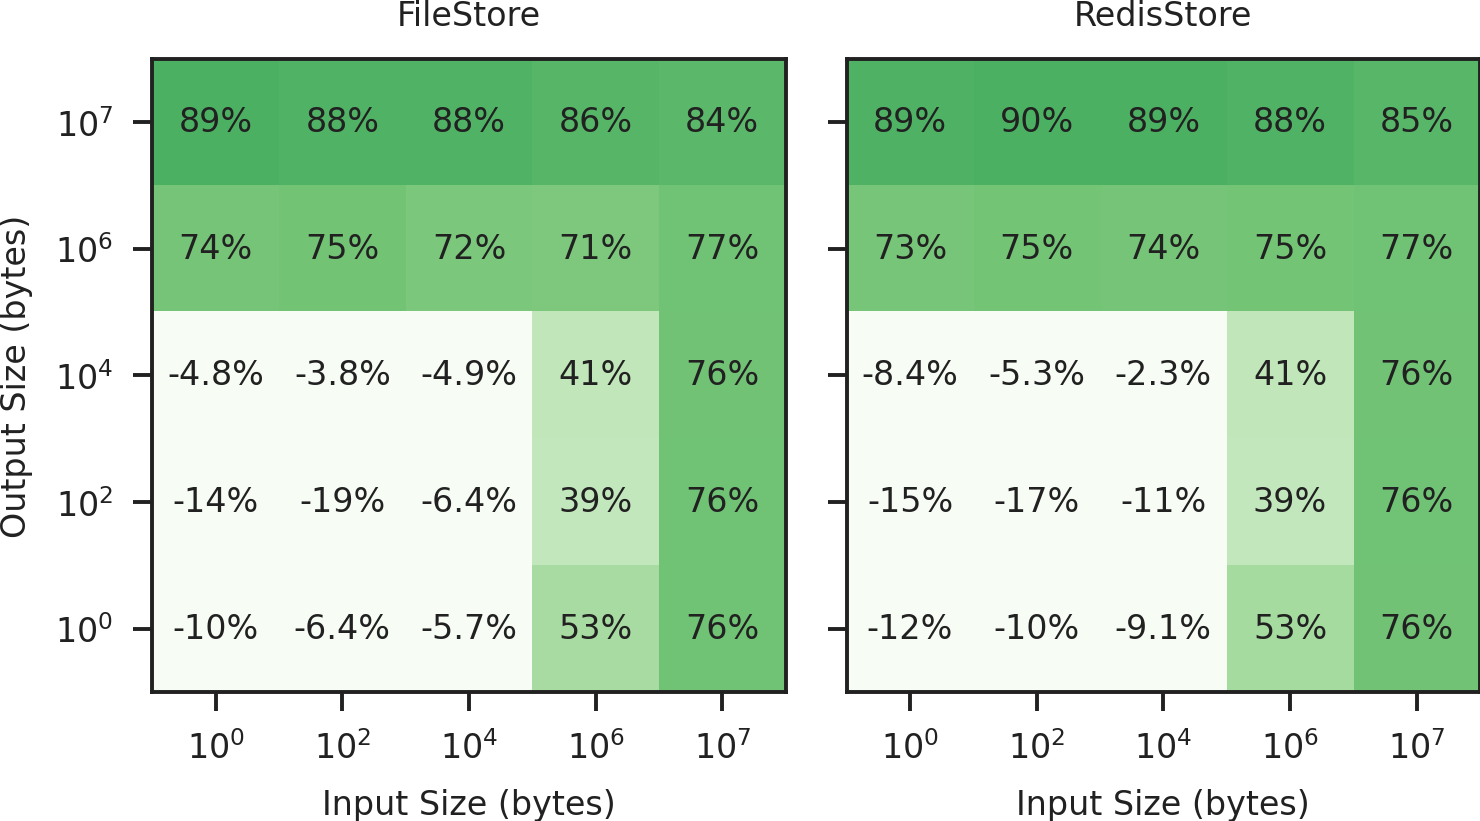

In [8]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(4, 6))

labels = ['$10^0$', '$10^2$', '$10^4$', '$10^6$', '$10^7$']

for change_data, ax in zip((filestore_changes, redisstore_changes), axs):
    xy = matrixify(change_data)
    caxes = ax.matshow(xy, cmap=matplotlib.cm.Greens, vmin=0, vmax=1.5)
    
    for y, row in enumerate(xy):
        for x, val in enumerate(row):
            val = 100*val
            ax.text(x, y, f'{val:0.0f}%' if val >= 10 or val <= -10 else f'{val:0.1f}%', ha='center', va='center', fontsize=6)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(range(5))
    ax.set_yticks(range(5))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(reversed(labels))

axs[0].set_title('FileStore')
axs[1].set_title('RedisStore')
axs[0].set_xlabel('Input Size (bytes)')
axs[1].set_xlabel('Input Size (bytes)')
axs[0].set_ylabel('Output Size (bytes)')

fig.tight_layout(h_pad=.5, w_pad=0.75)

**Takeaway:** As data sizes increase, transferring data via proxies using ProxyStore's File/RedisConnectors reduces overheads in the workflow engine (Colmena and Parsl in this case) which reduces round-trip task times.

## Experiment 3: Endpoint Client Performance

In [9]:
ROUTE_COLUMN = 'route'
PAYLOAD_COLUMN = 'payload_size_bytes'
WORKERS_COLUMN = 'workers'
LATENCY_AVG_COLUMN = 'avg_latency_ms'
LATENCY_STDEV_COLUMN = 'stdev_latency_ms'

def load(filepath: str) -> pandas.DataFrame:
    return pandas.read_csv(filepath)

DATA = load('results/endpoint-qps.csv')

In [10]:
def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def extract_series(data: pandas.DataFrame, route: str, payload_size: int) -> dict[str, list[str]]:
    data = rows_matching_column_value(data, ROUTE_COLUMN, route)
    data = rows_matching_column_value(data, PAYLOAD_COLUMN, payload_size)
    return {
        'workers': list(data[WORKERS_COLUMN]),
        'avg_latency': list(data[LATENCY_AVG_COLUMN]),
        'stdev_latency': list(data[LATENCY_STDEV_COLUMN]),
    }
    
def extract(data: pandas.DataFrame, route: str) -> dict[str, dict[str, list[str]]]:
    payloads = data[PAYLOAD_COLUMN].unique()
    return {payload: extract_series(data, route, payload) for payload in payloads}

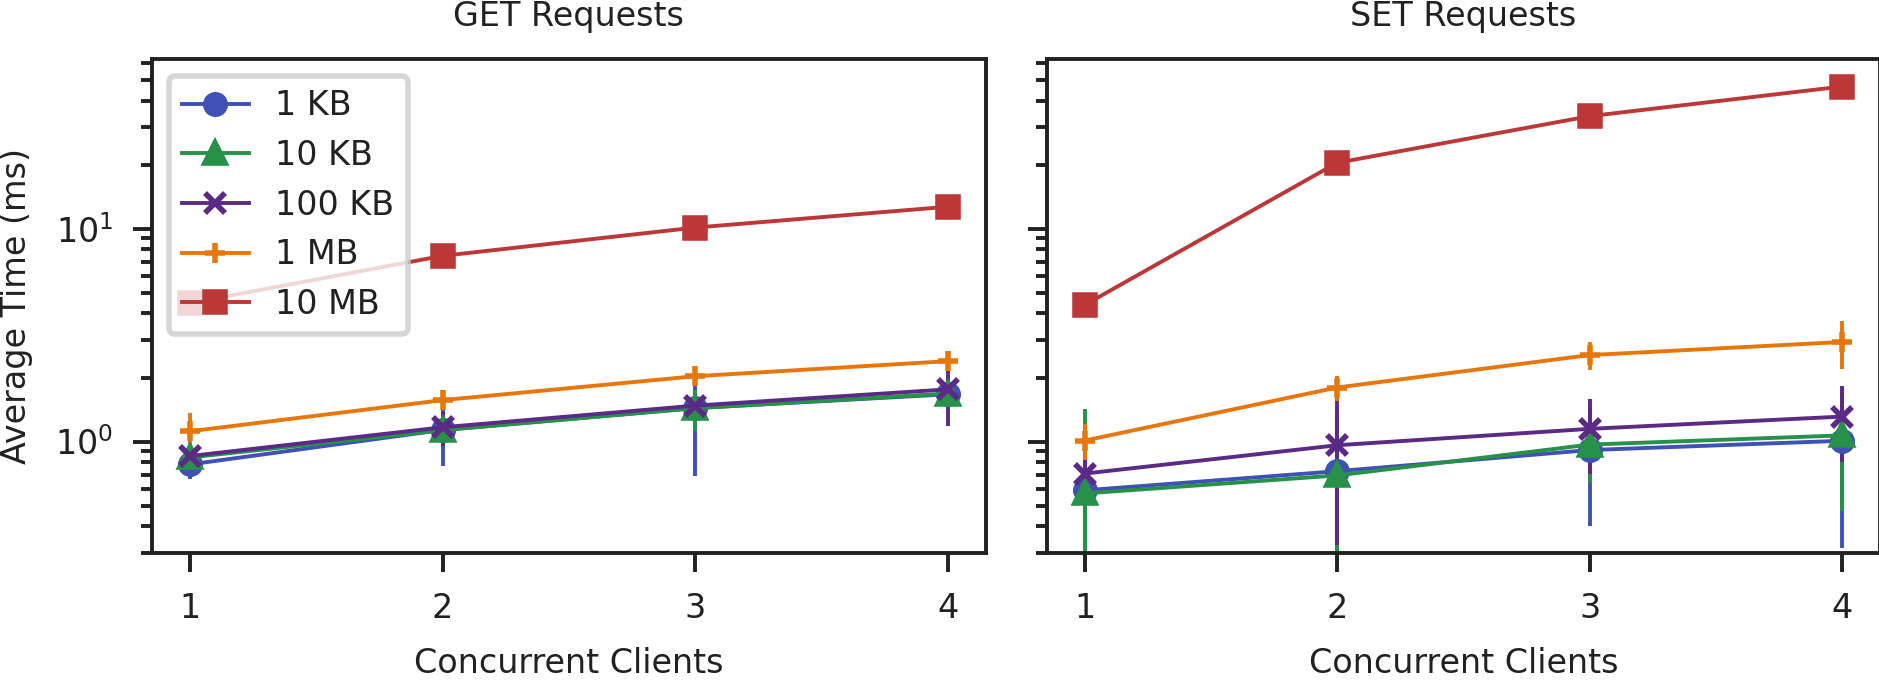

In [12]:
GET_DATA = extract(DATA, 'GET')
SET_DATA = extract(DATA, 'SET')

MARKERS = ('o', '^', 'x', '+', 's', 'P')
payload_labels = ['1 KB', '10 KB', '100 KB', '1 MB', '10 MB']

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 2))

for data, ax in zip((GET_DATA, SET_DATA), axs):
    ax.set_yscale('log', base=10)
    # ax.set_xscale('log', base=2)

    for i, (payload, series) in enumerate(data.items()):
        ax.errorbar(series['workers'], series['avg_latency'], series['stdev_latency'], marker=MARKERS[i], label=payload)

axs[0].set_xlabel('Concurrent Clients')
axs[1].set_xlabel('Concurrent Clients')
axs[0].set_ylabel('Average Time (ms)')
axs[0].set_title('GET Requests')
axs[1].set_title('SET Requests')

axs[0].set_xticks([1, 2, 3, 4])
axs[1].set_xticks([1, 2, 3, 4])
axs[0].set_ylim([0.3, None])

# Use integer x labels instead of powers of 2
axs[0].get_xaxis().set_major_formatter(mticker.FormatStrFormatter('%.0f'))
axs[1].get_xaxis().set_major_formatter(mticker.FormatStrFormatter('%.0f'))

handles, labels = axs[0].get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
axs[0].legend(handles, payload_labels, loc='upper left')

fig.tight_layout(h_pad=.5, w_pad=0.75)

**Takeaway:** Average query response time increases with payload size and number of concurrent clients. 